In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import faiss # Facebook AI Similarity Search
from tqdm.notebook import tqdm
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [ ]:
transform_image = T.Compose([
    T.ToTensor(), # 텐서로 변환
    T.Resize(224), # 224 사이즈로 리사이즈
    T.CenterCrop(224), # 가운데로만 자름
    T.Normalize([0.5], [0.5])]) # 숫자를 0과 1 사이로 정리 -> 정규화


def load_image(img_path) -> torch.Tensor: # 사진 파일을 받아서 모델에 넣을 수 있는 숫자 형태로 변환
    input_img = Image.open(img_path) # 사진 파일 열기
    transformed_img = transform_image(input_img)[:3].unsqueeze(0) # 위에서 만든 변환 적용, [:3] : 색깔 채널 3개(RGB)만 사용, unsqueeze(0) : 모양을 바꿔서 모델이 읽을 수 있도록 차원을 하나 추가 (모델이 [1, 3, 224, 224]형태로 받기 위해. [3, 224, 224] 형태로는 받을 수 없음.)

    return transformed_img


def create_index(files, model) -> faiss.IndexFlatL2: # 인덱스를 만들고 벡터를 저장하는 함수
    index = faiss.IndexFlatL2(384) # 384길이 숫자 배열들을 빠르게 비교할 수 있는 상자(인덱스)를 만든다.   [DINOv2 모델은 이미지를 숫자로 변환할 때, 결과 백터 길이가 384개 숫자로 되어있음.] (1, 384)는 "줄 1개, 칸 384개" 표
    all_embeddings = {} #  사진별 숫자 배열을 저장할 딕셔너리 [embedding뜻은 백터로 바꾼 값을 의미]

    with torch.no_grad():
        for _, file in enumerate(tqdm(files)): # 사진 파일들을 하나씩 꺼내면서 진행 바로 보여줌.
            embeddings = dinov2_vits14(load_image(file).to(device)) # 사진을 모델에 넣어서 숫자 벡터 얻음.
            embedding = embeddings[0].cpu().numpy() # 벡터를 CPU로 옮기고 넘파이 배열로 변환해요 (계산하기 편하게)

            reshaped_embedding = np.array(embedding).reshape(1, -1) # 배열 모양을 (1, 384)처럼 줄을 한 개로 맞춤. [(1 그리고 -1은 나머지 알아서 계산 -> 384를 의미)]

            all_embeddings[file] = reshaped_embedding.tolist() # 파일 이름을 키로 하고, 벡터를 값으로 딕셔너리에 저장
            index.add(reshaped_embedding) # 방금 만든 벡터를 faiss 인덱스에 넣음. 나중에 유사도 검색할 때 쓰기 위해 저장

    with open("all_embeddings.json", "w") as file: #모든 벡터를 json 파일로 저장 (다음에 빠르게 불러올 수 있게함) json = 데이터를 문자로 쉽게 저장하는 포맷
        file.write(json.dumps(all_embeddings))

    faiss.write_index(index, "data.bin") #faiss 인덱스를 "data.bin" 파일로 저장 [faiss 인덱스는 빠르게 검색할 수 있도록 특별한 구조로 저장, 즉, "미리 계산해둔 검색 상자"를 저장, faiss.read_index("data.bin")로 그대로 불러올 수 있어요.]

    return index, all_embeddings # 만들어진 인덱스와 딕셔너리를 함수 밖으로 내보냄

def search_index(input_index, input_embeddings, k=3) -> list: # 주어진 벡터랑 가장 가까운 벡터 k개 찾기
    _, results = input_index.search(np.array(input_embeddings[0].reshape(1, -1)), k)

    return results[0] # 검색된 벡터들의 순번(index)만 꺼냄


if __name__=="main": #.py 파일로 실행할 때만 아래 코드를 동작하게 함
    cwd = os.getcwd() #현재 폴더 경로 가져오기

    ROOT_DIR = os.path.join(cwd, "COCO-128-2/train/") # 유사한 이미지를 찾을 대상 풀(pool)
    files = os.listdir(ROOT_DIR)
    files = [os.path.join(ROOT_DIR, f)for f in files if f.lower().endswith(".jpg")]

    dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14") # DINOv2 모델을 인터넷에서 불러오기
    device = torch.device('cuda' if torch.is_available() else "cpu")
    dinov2_vits14.to(device)

    data_index, all_embeddings = create_index(files, dinov2_vits14) # 모든 학습 이미지에서 벡터를 만들고 인덱스를 생성

    input_file = "COCO-128-2/valid/000000000081_jpg.rf.5262c2db56ea4568d7d32def1bde3d06.jpg" # 유사도를 비교할 이미지 지정
    input_img = cv2.resize(cv2.imread(input_file), (416, 416)) # OpenCV로 이미지를 읽고 크기를 416x416으로 조정 [단순히 이미지를 시각화하거나 저장할 때 일정 크기로 맞추려고 416x416]

    with torch.no_grad():
        embedding = dinov2_vits14(load_image(input_file).to(device)) # 입력 이미지의 벡터를 생성
        results = search_index(data_index, np.array(embedding[0].cpu()).reshape(1, -1)) # 인덱스에서 유사한 이미지 순번을 찾음

        for i, index in enumerate(results): # 찾은 이미지 순번을 이용해 파일 이름 출력
            print("Image {i}: {files[index]}")

In [6]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "COCO-128-2/train/")
files = os.listdir(ROOT_DIR)
files = [os.path.join(ROOT_DIR, f) for f in files if f.lower().endswith(".jpg")]

dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

data_index, all_embeddings = create_index(files, dinov2_vits14)

input_file = "COCO-128-2/valid/000000000081_jpg.rf.5262c2db56ea4568d7d32def1bde3d06.jpg"
input_img = cv2.resize(cv2.imread(input_file), (416, 416))

with torch.no_grad():
    embedding = dinov2_vits14(load_image(input_file).to(device))
    results = search_index(data_index, np.array(embedding[0].cpu()).reshape(1, -1))

    for i, index in enumerate(results):
        print(f"Image {i}: {files[index]}")

Using cache found in /home/jonghyun/.cache/torch/hub/facebookresearch_dinov2_main


  0%|          | 0/128 [00:00<?, ?it/s]

Image 0: /home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000081_jpg.rf.5ac5126a29a5565691c27016453cb17b.jpg
Image 1: /home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000472_jpg.rf.68cb82fda7d6d5abec9e462eb191271a.jpg
Image 2: /home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000540_jpg.rf.d42cc5cec9a137294c1d0dd81cacceaf.jpg


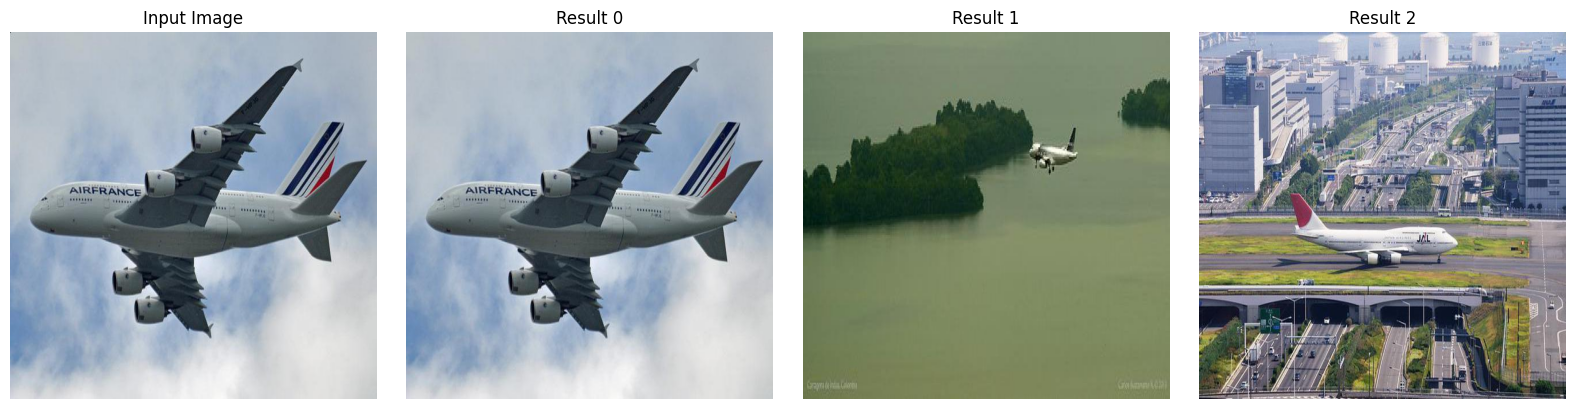

In [9]:
result_paths = [
    "/home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000081_jpg.rf.5ac5126a29a5565691c27016453cb17b.jpg",
    "/home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000472_jpg.rf.68cb82fda7d6d5abec9e462eb191271a.jpg",
    "/home/jonghyun/pytorch-prj/dino_v2/COCO-128-2/train/000000000540_jpg.rf.d42cc5cec9a137294c1d0dd81cacceaf.jpg",
]

input_path = "COCO-128-2/valid/000000000081_jpg.rf.5262c2db56ea4568d7d32def1bde3d06.jpg"

plt.figure(figsize=(16,4))

img = cv2.imread(input_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Input Image")

for idx, path in enumerate(result_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 4, idx + 2)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Result {idx}")

plt.tight_layout()
plt.show()